1. Nettoyage et Préparation des Données

In [1]:
import pandas as pd
import os
#Dans cette cellule, j'ai importé les bibliothèques nécessaires et défini une fonction pour charger des fichiers Excel depuis un dossier spécifique. J'ai utilisé pandas pour la manipulation des données et os pour interagir avec le système de fichiers. Les données sont fusionnées en un seul DataFrame, et certaines colonnes non nécessaires sont supprimées.

# Chemin du dossier contenant les fichiers Excel
chemin_dossier = 'C:\\Users\\cocog\\OneDrive\\Documents\\ESILV\\S9\\Machine Learning NLP\\Projet2\\Traduction avis clients'

# Fonction pour charger les fichiers Excel dans un DataFrame et les fusionner
def charger_fichiers_excel(chemin):
    fichiers_excel = [f for f in os.listdir(chemin) if f.endswith('.xlsx')]
    dataframes = [pd.read_excel(os.path.join(chemin, fichier)) for fichier in fichiers_excel]
    return pd.concat(dataframes, ignore_index=True)

# Chargement des données
data = charger_fichiers_excel(chemin_dossier)
data = data.drop(columns=['avis_cor', 'avis_cor_en'])  # Supprimer les colonnes non nécessaires




In [1]:
data['avis'].head()
#Ici, j'affiche simplement les premières lignes de la colonne 'avis' pour inspecter les données.



NameError: name 'data' is not defined

2. Nettoyage de Texte



In [3]:
import re
# J'introduis une fonction clean_text pour nettoyer le texte. Cette fonction enlève les balises HTML, filtre les caractères spéciaux, convertit le texte en minuscules et supprime les espaces excédentaires. Ensuite, j'applique cette fonction aux colonnes 'avis' et 'avis_en' du DataFrame.
# Fonction pour nettoyer le texte
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)  # Supprimer les balises HTML
    text = re.sub(r'[^a-zA-Zéèêëàâäôöûüçîï0-9\s]', ' ', text)  # Filtrer les caractères spéciaux
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces excédentaires
    return text

data['avis'] = data['avis'].apply(clean_text)
data['avis_en'] = data['avis_en'].apply(clean_text)


In [7]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
#J'utilise sumy, une bibliothèque de résumé de texte, pour créer une fonction resume_avis_sumy. Cette fonction génère un résumé des avis en prenant en compte la langue et le nombre de phrases souhaité. Le résumé est ensuite ajouté au DataFrame.

def resume_avis_sumy(text, langue='french', nombre_phrases=2):
    parser = PlaintextParser.from_string(text, Tokenizer(langue))
    summarizer = LsaSummarizer()
    resume = summarizer(parser.document, nombre_phrases)
    return ' '.join([str(phrase) for phrase in resume])

data['avis_resume'] = data['avis'].apply(lambda x: resume_avis_sumy(x))


3. Analyse Exploratoire

In [2]:
#Dans cette cellule, je réalise une analyse exploratoire de base. Je fournis une description statistique des notes, compte le nombre d'avis par assureur et par type de produit, et affiche ces informations
# Description statistique des notes
description_notes = data['note'].describe()

# Compter le nombre d'avis par assureur et par type de produit
avis_par_assureur = data['assureur'].value_counts()
avis_par_produit = data['produit'].value_counts()

# Afficher les premiers éléments pour chaque catégorie
print(description_notes, avis_par_assureur.head(), avis_par_produit.head())


NameError: name 'data' is not defined

4. Prétraitement pour NLP


In [9]:
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
#J'initialise un modèle spacy pour le français et crée une fonction de prétraitement NLP. Cette fonction utilise spacy pour lemmatiser le texte et supprimer les stop-words. Le texte prétraité est ajouté au DataFrame
nlp = spacy.load('fr_core_news_sm', disable=['tagger', 'parser', 'ner'])

# Fonction de prétraitement NLP
def nlp_preprocessing(texts):
    docs = nlp.pipe(texts)
    processed_texts = []
    for doc in docs:
        tokens = [token.lemma_ for token in doc if token.text.lower() not in fr_stop]
        processed_texts.append(' '.join(tokens))
    return processed_texts

data['avis_processed'] = nlp_preprocessing(data['avis'])


5. Visualisation des Fréquences de Mots



C:\Users\cocog\AppData\Local\Temp\ipykernel_15084\2929981830.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')


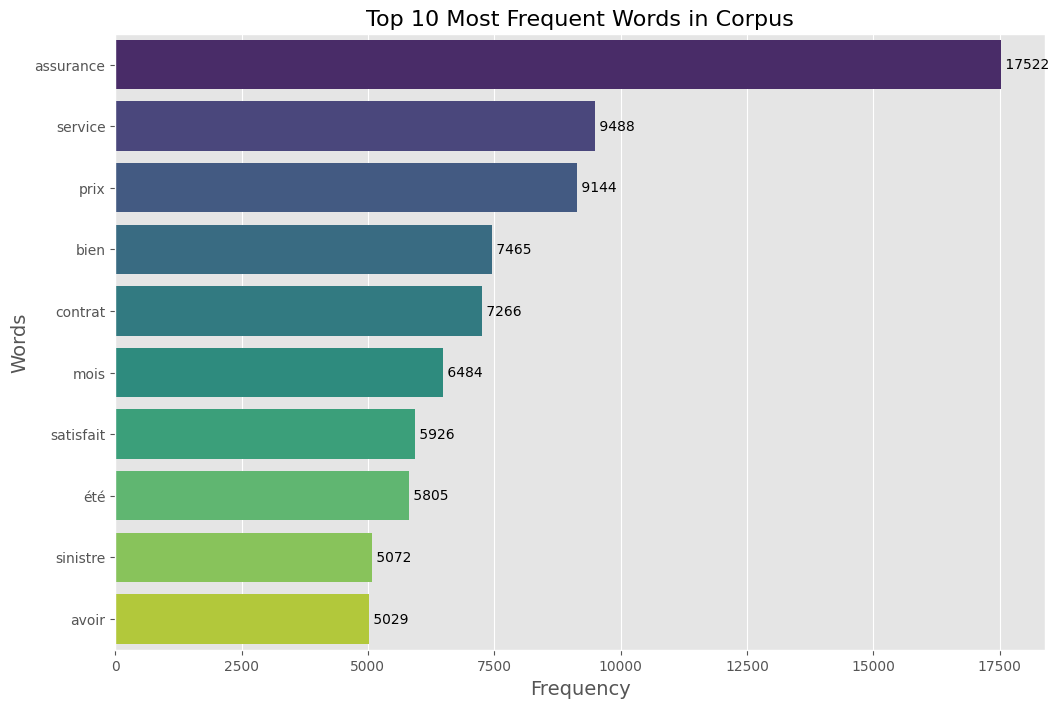

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
#voici une liste non exaustive des mots qu'on retrouve souvent dans les textes
french_stop_words = [
    'au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 
    'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 
    'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 
    'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 
    'vous','les','trs','jai','cest','tout','ils','est','suis','plus','très','sont','fait','cette',
    'depuis','a','à','!','ai','car','faire','j','c','n','alor','alors','d','m','donc','chez','sans'
]
#Dans cette cellule, j'ai écrit une fonction plot_top_words pour visualiser les mots les plus fréquents dans le corpus. J'utilise CountVectorizer de scikit-learn pour transformer le texte en un sac de mots et calculer les fréquences. Ensuite, je crée un graphique en barres avec Matplotlib et Seaborn pour afficher les résultats.
def plot_top_words(corpus, n_top_words=20, n_gram=1):
    vec = CountVectorizer(stop_words=french_stop_words, ngram_range=(n_gram, n_gram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n_top_words]
    
    top_df = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

    # Appliquer un style de graphique
    plt.style.use('ggplot')

    # Création du graphique
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')

    # Ajout de titres et d'étiquettes
    plt.title('Top {} Most Frequent Words in Corpus'.format(n_top_words), fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)

    # Ajouter des annotations
    for index, value in enumerate(top_df['Frequency']):
        plt.text(value, index, f' {value:.0f}', va='center')

    # Afficher le graphique
    plt.show()

plot_top_words(data['avis'], n_top_words=10, n_gram=1)




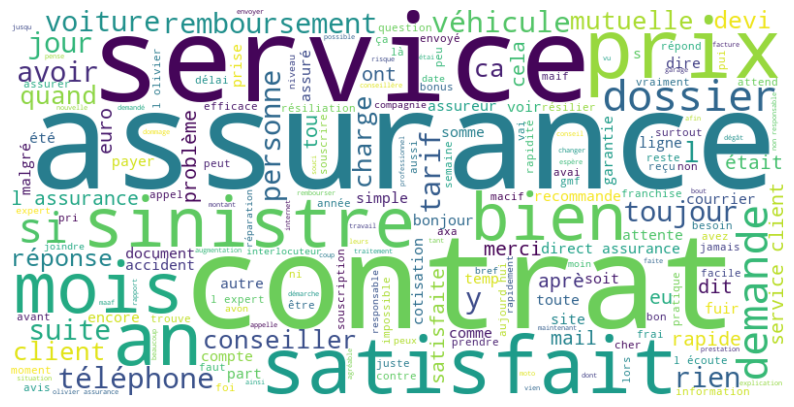

In [21]:
from wordcloud import WordCloud
#Ici, j'utilise la bibliothèque WordCloud pour créer et afficher un nuage de mots du corpus. Ce visuel est utile pour avoir une idée rapide des mots les plus récurrents dans les avis.
def plot_wordcloud(corpus):
    text = ' '.join(corpus)
    wordcloud = WordCloud(stopwords=french_stop_words, background_color='white', width=800, height=400).generate(text)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(data['avis'])


C:\Users\cocog\AppData\Local\Temp\ipykernel_15084\2929981830.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')


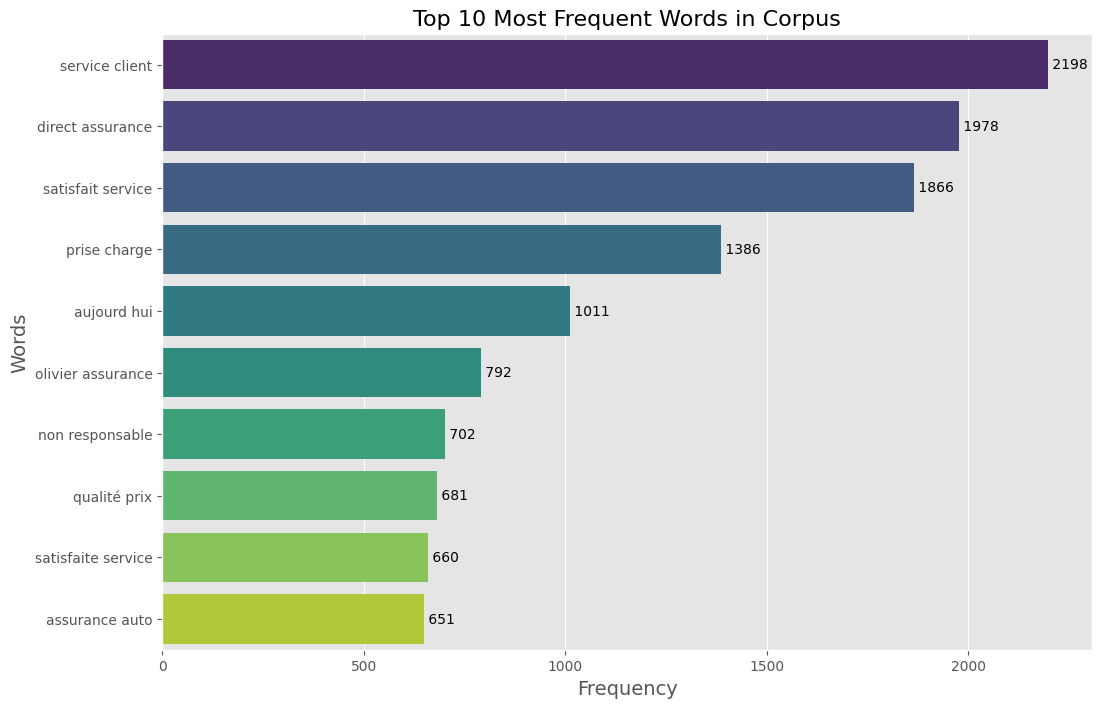

C:\Users\cocog\AppData\Local\Temp\ipykernel_15084\2929981830.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_df, palette='viridis')


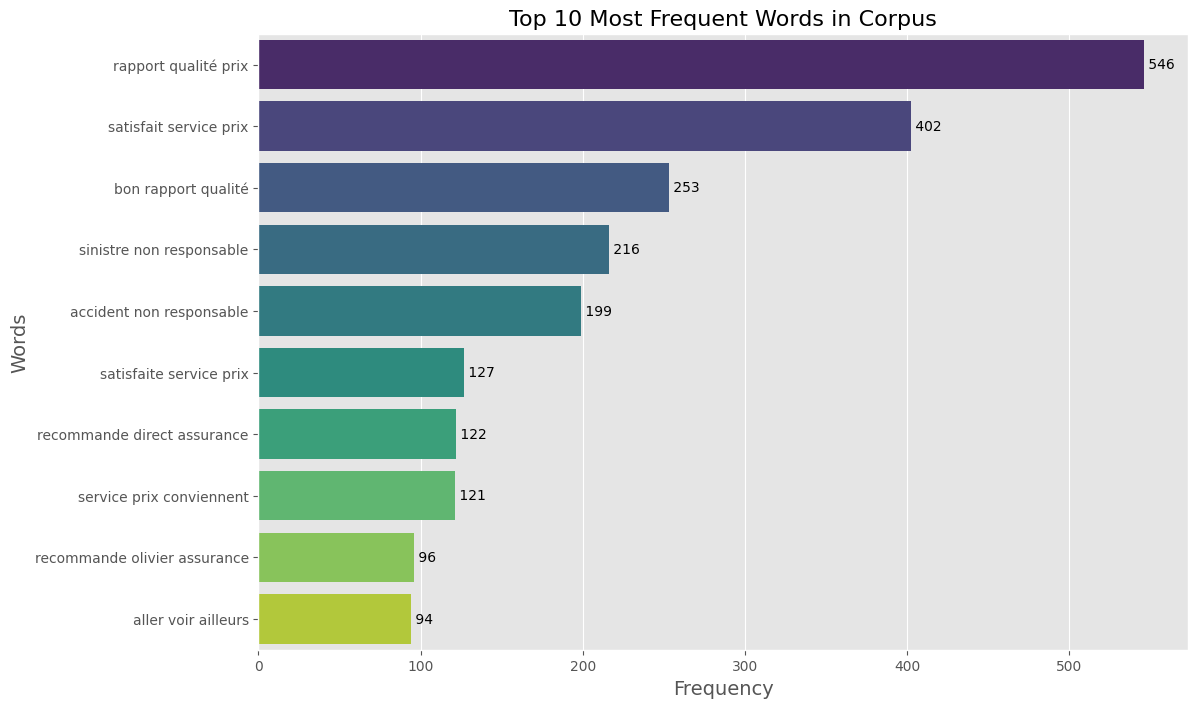

In [22]:
plot_top_words(data['avis'], n_top_words=10, n_gram=2)  # Pour les bigrammes
plot_top_words(data['avis'], n_top_words=10, n_gram=3)  # Pour les trigrammes


In [23]:
data.head()
#J'affiche simplement les premières lignes du DataFrame pour vérifier les modifications apportées jusqu'à présent.

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_resume,avis_processed
0,4.0,audurier-c-136272,la personne au téléphone était clair et sympat...,L'olivier Assurance,auto,train,06/10/2021,01/10/2021,the person on the phone was clear and friendly...,la personne au téléphone était clair et sympat...,téléphone clair sympathique m bien expliqué re...
1,4.0,paul-a-122970,satisfait réactivité simplicité prix attractif...,APRIL Moto,moto,train,09/07/2021,01/07/2021,satisfied reactivity simplicity attractive pri...,satisfait réactivité simplicité prix attractif...,satisfait réactivité simplicité prix attractif...
2,1.0,kitty-38517,assureur à fuir n assure pas ses responsabilit...,SwissLife,vie,train,15/10/2020,01/10/2020,insurer to flee does not ensure its responsibi...,assureur à fuir n assure pas ses responsabilit...,assureur fuir n assurer responsabilité agent d...
3,1.0,laure97134-87907,voilà 3 mois que la gmf me fait attendre pour ...,GMF,habitation,train,03/03/2020,01/03/2020,the gmf has been waiting for a water damage fo...,voilà 3 mois que la gmf me fait attendre pour ...,3 mois gmf attendre dégât eau j contrat
4,3.0,bourouane-l-129916,je suis bien avec cet assurance elle est prati...,L'olivier Assurance,auto,train,28/08/2021,01/08/2021,i am good with this insurance she is practical...,je suis bien avec cet assurance elle est prati...,bien assurance pratique moin cher trouver mieu...


6. Correction Orthographique (Optimisation)



In [24]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
#Ici, j'introduis l'utilisation de TextBlob pour effectuer une correction orthographique. J'ai également créé un cache pour optimiser les performances, en stockant les résultats des corrections précédentes. La fonction développée permet de corriger automatiquement les fautes d'orthographe dans les avis.
corrected_cache = {}

# Fonction optimisée pour la correction orthographique
def correct_spelling_fr_optimized(text):
    corrected_text = []
    for word in text.split():
        if word not in corrected_cache:
            blob = TextBlob(word, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
            corrected_word = ' '.join([w.correct() for w in blob.words])
            corrected_cache[word] = corrected_word
        corrected_text.append(corrected_cache[word])
    return ' '.join(corrected_text)

data['avis_corrected'] = data['avis'].apply(correct_spelling_fr_optimized)


c:\Users\cocog\AppData\Local\Programs\Python\Python312\Lib\site-packages\textblob\_text.py:218: SyntaxWarning: invalid escape sequence '\.'
  RE_ABBR1 = re.compile("^[A-Za-z]\.$")       # single letter, "T. De Smedt"
c:\Users\cocog\AppData\Local\Programs\Python\Python312\Lib\site-packages\textblob\_text.py:219: SyntaxWarning: invalid escape sequence '\.'
  RE_ABBR2 = re.compile("^([A-Za-z]\.)+$")    # alternating letters, "U.S."


KeyboardInterrupt: 

In [25]:
#Ici, j'utilise googletrans, une bibliothèque de traduction, pour traduire les avis en anglais. Cette étape est utile pour la préparation des données pour certaines techniques de NLP qui nécessitent ou fonctionnent mieux avec des textes en anglais.
from googletrans import Translator

translator = Translator()

def translate_text(text, target_language='en'):
    return translator.translate(text, dest=target_language).text

data['avis_translated'] = data['avis'].apply(lambda x: translate_text(x, 'en'))


KeyboardInterrupt: 

8. Analyse des Sentiments



In [51]:
from textblob import TextBlob
#J'implémente l'analyse des sentiments en utilisant TextBlob. Cette fonction analyse le texte et classe les sentiments comme positifs, négatifs ou neutres. Les résultats sont ajoutés au DataFrame et je compte ensuite le nombre de chaque type de sentiment.
# Fonction pour l'analyse des sentiments
def analyse_et_classifie_sentiments(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.0001:
        return 'positif'
    elif polarity < -0.0001:
        return 'négatif'
    else:
        return 'neutre'

data['sentiment'] = data['avis'].apply(analyse_et_classifie_sentiments)
nombre_sentiments = data['sentiment'].value_counts()

# Affichage des résultats
print(nombre_sentiments)


sentiment
neutre     25718
positif     5960
négatif     2757
Name: count, dtype: int64


9. Modélisation de Sujets avec LDA



In [30]:
from gensim import corpora, models
#J'entraîne un modèle Word2Vec avec gensim sur les avis. Ce modèle est utilisé pour créer des embeddings de mots qui capturent les relations sémantiques. J'explore ensuite les mots similaires à un terme donné pour démontrer les capacités du modèle.
# Préparation des données pour LDA
texts = [[word for word in doc.split() if word.lower() not in french_stop_words] for doc in data['avis']]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Filtrage des mots
corpus = [dictionary.doc2bow(text) for text in texts]

# Création du modèle LDA
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Affichage des sujets
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.021*"assurance" + 0.018*"cher" + 0.017*"prix" + 0.016*"moins" + 0.016*"année" + 0.011*"peu" + 0.010*"autres" + 0.010*"contrat" + 0.009*"tarif" + 0.009*"ans"
Topic: 1 
Words: 0.036*"l" + 0.022*"assurance" + 0.017*"sinistre" + 0.013*"véhicule" + 0.012*"ans" + 0.011*"voiture" + 0.008*"expert" + 0.008*"accident" + 0.008*"non" + 0.008*"responsable"
Topic: 2 
Words: 0.032*"l" + 0.021*"bien" + 0.015*"été" + 0.012*"merci" + 0.012*"écoute" + 0.012*"eu" + 0.011*"téléphone" + 0.009*"mutuelle" + 0.009*"toujours" + 0.008*"bonne"
Topic: 3 
Words: 0.016*"l" + 0.013*"mois" + 0.009*"contrat" + 0.009*"assurance" + 0.008*"toujours" + 0.007*"dossier" + 0.006*"rien" + 0.006*"avoir" + 0.006*"service" + 0.006*"demande"
Topic: 4 
Words: 0.050*"prix" + 0.042*"assurance" + 0.041*"service" + 0.040*"satisfait" + 0.031*"l" + 0.025*"rapide" + 0.020*"recommande" + 0.018*"simple" + 0.014*"merci" + 0.012*"bien"


Topic 0 : Il pourrait être lié au service client, avec des mots clés comme "service", "téléphone", "client".

Topic 1 : Ce thème semble concerner les aspects contractuels ou administratifs, avec des termes comme "mois", "mutuelle", "contrat".

Topic 2 : Semble également lié à des contrats ou des aspects financiers, avec des mots comme "contrat", "euros", "assurance".

Topic 3 : Peut-être lié aux sinistres ou aux assurances véhicules, avec des mots comme "sinistre", "véhicule", "voiture".

Topic 4 : Semble concerner la satisfaction des clients, avec des mots comme "prix", "satisfait", "recommande".

10. Entraînement de Word2Vec pour l'Embedding de Mots



In [31]:
from gensim.models import Word2Vec
#Dans cette cellule, je convertis un modèle pré-entraîné GloVe en format Word2Vec pour une utilisation avec gensim. Cette étape est utile pour utiliser des embeddings de mots pré-entraînés dans le modèle.
sentences = [sentence.split() for sentence in data['avis']]
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Trouver des mots similaires à 'assurance'
similar_words = model_w2v.wv.most_similar('assurance', topn=10)
for word, score in similar_words:
    print(f"{word}: {score:.4f}")


assurances: 0.6180
compagnie: 0.5938
histoire: 0.5935
mutuelle: 0.5804
option: 0.5779
asuurance: 0.5601
offre: 0.5594
expérience: 0.5541
mutuel: 0.5463
société: 0.5244


In [32]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

# Charger GloVe (ajustez le chemin vers le modèle GloVe téléchargé)
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

# Charger les embeddings GloVe comme modèle Word2Vec
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Comparer les mots similaires entre GloVe et Word2Vec
mot_test = 'assurance'
print("Word2Vec:", model_w2v.wv.most_similar(mot_test))
print("GloVe:", glove_model.most_similar(mot_test))


C:\Users\cocog\AppData\Local\Temp\ipykernel_15084\3314441721.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

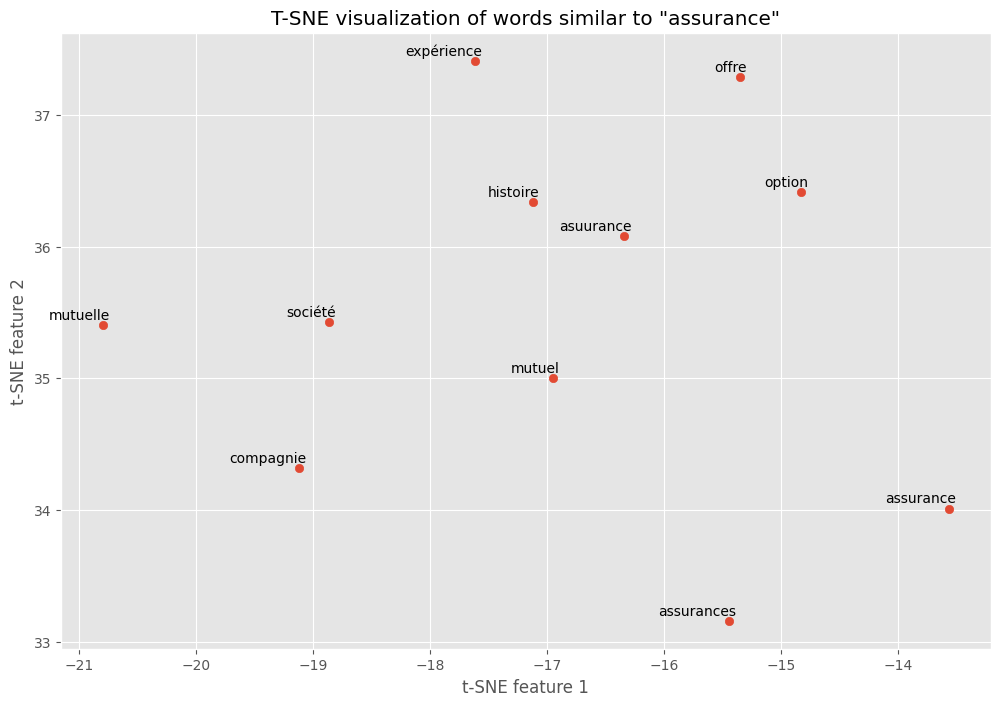

In [35]:
#Dans cette cellule, je définis une fonction afficher_tsne pour visualiser les embeddings de mots à l'aide de t-SNE. Cette méthode réduit la dimensionnalité des embeddings pour une représentation en 2D. Je l'applique sur les mots similaires à un mot donné et affiche les résultats sous forme de graphique.
def afficher_tsne(model, word, num_similar=10):
    similar_words = [word] + [w[0] for w in model.wv.most_similar(word, topn=num_similar)]
    embeddings = np.array([model.wv[w] for w in similar_words])
    
    # Réduire la valeur de perplexité si le nombre de mots similaires est faible
    perplexite = min(5, len(similar_words) - 1)  # La perplexité doit être inférieure au nombre d'échantillons

    tsne = TSNE(n_components=2, perplexity=perplexite)
    Y = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(similar_words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.title(f'T-SNE visualization of words similar to "{word}"')
    plt.show()

afficher_tsne(model_w2v, 'assurance')


Visualisation des Embeddings avec Matplotlib et Tensorboard


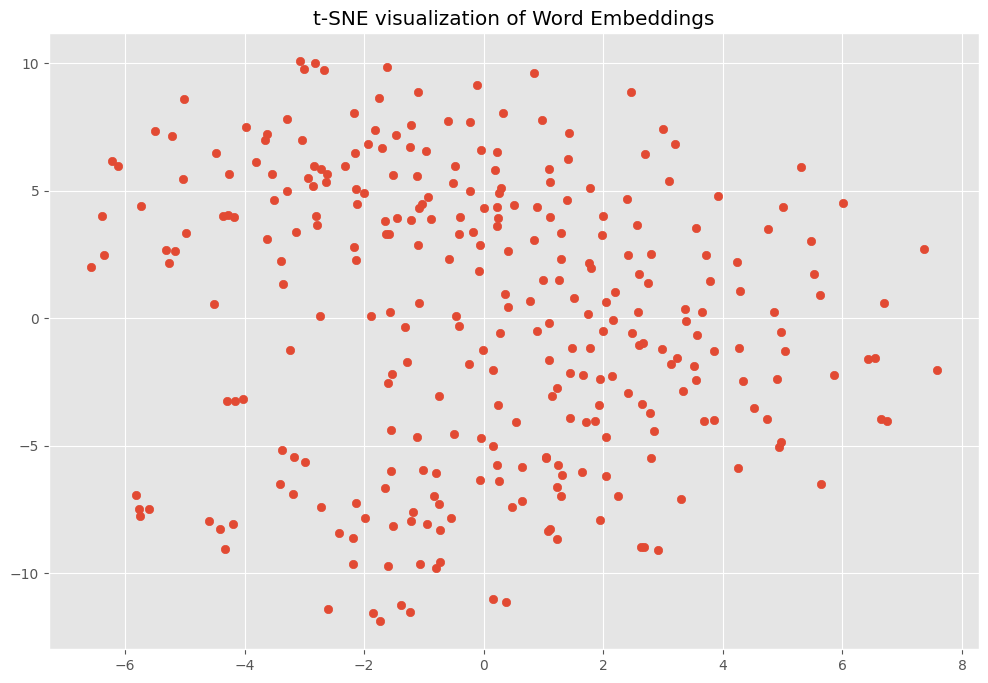

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
#Ici, j'utilise PCA pour réduire la dimensionnalité des embeddings de Word2Vec, puis j'applique t-SNE pour une visualisation en 2D. Cette visualisation est réalisée avec Matplotlib, montrant la distribution spatiale des mots dans l'espace vectoriel.
words = list(model_w2v.wv.index_to_key)

X_pca = np.array([model_w2v.wv[word] for word in words])

# Réduire d'abord la dimensionnalité avec PCA
pca = PCA(n_components=100)  # Réduction à 50 dimensions
X_pca_reduit = pca.fit_transform(X_pca)

# Sélectionner un sous-ensemble de données plus petit pour t-SNE
np.random.seed(42)
indices = np.random.choice(range(len(X_pca_reduit)), size=300, replace=False)  # Réduire la taille de l'échantillon
X_sample = X_pca_reduit[indices]

# Appliquer t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, n_jobs=4)
X_tsne = tsne.fit_transform(X_sample)

# Visualisation
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE visualization of Word Embeddings')
plt.show()


4. Mise en Œuvre de la Distance Euclidienne ou Cosinus


In [45]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
#Dans cette cellule, je calcule la distance euclidienne et la similarité cosinus entre les embeddings de mots. J'utilise les fonctions euclidean_distances et cosine_similarity de scikit-learn pour cela. Les résultats donnent un aperçu de la proximité des mots dans l'espace vectoriel.
# Calcul de la distance euclidienne entre les deux premiers points
dist_euclid = euclidean_distances(X_tsne[0:1], X_tsne[1:2])

# Calcul de la similarité cosinus entre les deux premiers points
sim_cosine = cosine_similarity(X_tsne[0:1], X_tsne[1:2])

# Affichage des résultats
print("Distance euclidienne entre les deux premiers points :", dist_euclid[0][0])
print("Similarité cosinus entre les deux premiers points :", sim_cosine[0][0])


Distance euclidienne entre les deux premiers points : 2.4235659
Similarité cosinus entre les deux premiers points : 0.9654936


Recherche sémantique

In [46]:
#Ici, j'implémente une fonction de recherche sémantique qui utilise les embeddings de mots pour trouver les mots les plus similaires à un terme donné. La fonction utilise la similarité cosinus pour identifier les mots les plus proches dans l'espace vectoriel.
# Fonction pour la recherche sémantique
def recherche_semantique(query, model, topn=5):
    query_vec = model.wv[query]
    similarities = model.wv.most_similar([query_vec], topn=topn)
    return similarities

recherche_semantique_resultats = recherche_semantique("assurance", model_w2v)
print(recherche_semantique_resultats)


[('assurance', 1.0000001192092896), ('assurances', 0.6179617047309875), ('compagnie', 0.5937750339508057), ('histoire', 0.5935269594192505), ('mutuelle', 0.5804294943809509)]


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#Dans cette cellule, je mets en œuvre un modèle de classification basé sur une machine à vecteurs de support (SVM) pour la classification des sentiments. J'utilise TfidfVectorizer pour convertir les avis en vecteurs TF-IDF, puis je divise les données en ensembles d'entraînement et de test. Après l'entraînement du modèle SVM, je l'évalue en utilisant un rapport de classification.
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(data['avis']).toarray()
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearSVC(dual=False)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

      neutre       0.96      1.00      0.98      5134
     négatif       0.98      0.83      0.90       569
     positif       0.98      0.89      0.93      1184

    accuracy                           0.97      6887
   macro avg       0.97      0.91      0.94      6887
weighted avg       0.97      0.97      0.97      6887



In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#Ici, j'explore un autre modèle de classification, le Random Forest, pour comparer ses performances avec le modèle SVM précédent. Après l'entraînement, j'évalue la précision du modèle Random Forest et la compare avec celle du modèle SVM.
# Un autre modèle pour la comparaison (Random Forest)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Comparer les performances
print("SVM Accuracy:", accuracy_score(y_test, predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))


SVM Accuracy: 0.9661681428778859
Random Forest Accuracy: 0.9593436910120517


In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(input_dim=len(tfidf.vocabulary_), output_dim=100, input_length=500))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


ModuleNotFoundError: No module named 'tensorflow'

In [19]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def convert_example_to_feature(review):
    return tokenizer.encode_plus(review, 
                                 add_special_tokens=True,  # Ajouter '[CLS]' et '[SEP]'
                                 max_length=512,  # Taille maximale de tokenisation
                                 pad_to_max_length=True,  # Ajouter des '[PAD]' si nécessaire
                                 return_attention_mask=True)

# Création des features
data['input_ids'] = data['avis'].apply(lambda x: convert_example_to_feature(x)['input_ids'])
data['attention_mask'] = data['avis'].apply(lambda x: convert_example_to_feature(x)['attention_mask'])

# Conversion en tenseurs TensorFlow
train_inputs = tf.convert_to_tensor(data['input_ids'])
train_masks = tf.convert_to_tensor(data['attention_mask'])
train_labels = tf.convert_to_tensor(data['label'])
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_masks, train_labels))
train_dataset = train_dataset.shuffle(len(data)).batch(32)

# Supposons que vous ayez également des datasets de validation 'validation_data'
# Vous pouvez les préparer de la même manière
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3, validation_data=validation_data)


ModuleNotFoundError: No module named 'transformers'